In [5]:
import xarray as xr
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import cartopy.crs as ccrs
import matplotlib.colors as colors
datapath='/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/MF_ML_PREDICT/'
models=['graphcast_','graphcast-oper','pangu_','pangu-oper','fcnv2_dawn','ifs']
references=['era','ifs_init']
figpath='/users/mfeldman/figs/spatial/'
c1='#648fff' #lightblue
c2='#785ef0' #indigo
c3='#dc267f' #magenta
c4='#fe6100' #orange
c5='#ffb000' #gold
c6='#000000' #black



In [22]:

era_ref=xr.open_dataset(datapath+'USA_tor_2020_era.nc').sortby('latitude').fillna(0)
cape=era_ref.cape.squeeze().values
wms=(cape * 2)**0.5 * era_ref.bs_06
era_ref=era_ref.assign(wms=lambda era_ref: wms)
nn=0
mm=0
for mm in range(6)[:1]:
    var=['cape','cin','bs_06','bs_03','bs_01','wms'][mm]
    tit=['CAPE [J kg$^{-1}$]','CIN [J kg$^{-1}$]','0-6km shear [m s$^{-1}$]','0-3km shear [m s$^{-1}$]',
         '0-1km shear [m s$^{-1}$]','wmax-shear [m$^2$ s$^{-2}$]'][mm]
    vm=[3000,500,55,50,30,2000][mm]
    vl=[100,10,5,1,1,100][mm]
    l1=[300,-100,10,5,5,300][mm]
    l2=[1000,-300,40,30,20,500][mm]
    f1=[1,-1,1,1,1,1][mm]

    cmd = colors.LinearSegmentedColormap.from_list('mycmap', ['#0072BC', '#FFFFFF', '#BE3825'])        
    cm= colors.LinearSegmentedColormap.from_list('mycmap', ['#FFFFFF', '#BE3825'])
    cm.set_under(color="grey")
    cm.set_bad(color="grey")
    print('making plot',var)
    p = era_ref[var].sel(latitude=slice(20,40),longitude=slice(260,290)).plot(x='longitude', y='latitude', col='time', col_wrap=4,
                transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()},
                cmap=cm,vmin=vl,vmax=vm,levels=np.arange(vl,vm,np.ceil(vm/20)),extend='both')# col_wrap=4)
    for ax in p.axs.flat:
                    ax.coastlines()
    f=p.fig
    f.savefig(figpath+'plot_era5'+'_'+var+'.png',  dpi=300, bbox_inches='tight')
    plt.close()

    for nn in range(len(models))[:]:
        kw=['lat','lat','latitude','latitude','latitude','latitude'][nn]
        kw1=['lon','lon','longitude','longitude','longitude','longitude'][nn]
        kw2=['prediction_timedelta','prediction_timedelta','prediction_timedelta','prediction_timedelta','time','prediction_timedelta'][nn]
        
        model=models[nn]
        color=[c1,c2,c3,c4,c5,c6][nn]
        print(model)

        files=sorted(glob(datapath+'USA_tor_2020_'+model+'*2020*.nc'),reverse=True)
       

        for file in range(len(files))[:-3]:
            #print(file)
            model_set=xr.open_dataset(files[file]).sortby(kw).fillna(0).squeeze()
            capem=model_set.cape.squeeze().values
            wms=(capem * 2)**0.5 * model_set.bs_06
            model_set=model_set.assign(wms=lambda model_set: wms)
                        
            init=files[file][-13:-3]
            
            
            #-- Color schemes
            cmd = colors.LinearSegmentedColormap.from_list('mycmap', ['#0072BC', '#FFFFFF', '#BE3825'])        
            cm= colors.LinearSegmentedColormap.from_list('mycmap', ['#FFFFFF', '#BE3825'])
            cm.set_under(color="grey")
            cm.set_bad(color="grey")
            #cmd=plt.cm.RdBu
            #print('making plot')
            levels=np.arange(100,2600,300)#np.arange(vl,vm,np.ceil(vm/20))
            p = model_set[var].sel(**{kw: slice(20,40)},**{kw1: slice(260,290)}).plot.contourf(x=kw1, y=kw, col=kw2, col_wrap=4,
                        transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()},
                        cmap=cm,vmin=vl,vmax=vm,levels=levels,extend='both')# col_wrap=4)
            for ax in p.axs.flat:
                            ax.coastlines()
            f=p.fig
            f.savefig(figpath+'plot_'+model+'_'+init+'_'+var+'.png',  dpi=300, bbox_inches='tight')
            plt.close()
            
            #print('computing delta')
            d_model_set = model_set[var].sel(**{kw: slice(20,40)},**{kw1: slice(260,290)}).squeeze() - \
                            era_ref[var].sel(latitude=slice(20,40),longitude=slice(260,290)).squeeze().values
                
            #print('making plot')
            levels=np.append(np.arange(-2500,-90,300),levels)
            #levels=np.delete(np.arange(-vm,vm+np.ceil(2*vm/20),np.ceil(2*vm/20)),10)#
            p = d_model_set.plot.contourf(x=kw1, y=kw, col=kw2, col_wrap=4,
                        transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()},
                        cmap=cmd,vmin=-vm,vmax=vm,levels=levels,extend='both')# col_wrap=4)
            for ax in p.axs.flat:
                            ax.coastlines()
            f=p.fig
            f.savefig(figpath+'deltaplot_'+model+'_'+init+'_'+var+'.png',  dpi=300, bbox_inches='tight')
            plt.close()
            
            # p = d_model_set[var].sel(latitude=slice(20,40),longitude=slice(260,290)).plot(x="longitude", y="latitude", col="time", col_wrap=4,transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()}\
            #             ,cmap=cmd,vmin=-vm,vmax=vm,levels=np.arange(-vm,vm,int(2*vm/20)),extend='both')# col_wrap=4)
            # for ax in p.axs.flat:
            #                 ax.coastlines()
            # f=p.fig
            # f.savefig(figpath+'/spatial/deltaplot_'+model+'_'+init+'_'+var+'.png',  dpi=300, bbox_inches='tight')
            # plt.close()





making plot cape
graphcast_
graphcast-oper
pangu_
pangu-oper
fcnv2_dawn
ifs


In [9]:
levels=np.delete(np.arange(-vm,vm+np.ceil(2*vm/20),np.ceil(2*vm/20)),10)
print(levels)

[-500. -450. -400. -350. -300. -250. -200. -150. -100.  -50.   50.  100.
  150.  200.  250.  300.  350.  400.  450.  500.]


In [17]:
era_ref=xr.open_dataset(datapath+'USA_tor_2020_era.nc').sortby('latitude').fillna(0).sel(latitude=slice(20,40),longitude=slice(260,290))
cape=era_ref.cape.squeeze().values
wms=(cape * 2)**0.5 * era_ref.bs_06
era_ref=era_ref.assign(wms=lambda era_ref: wms)
np.nanmin(era_ref.wms)

0.0

In [18]:
year=2020; month=4; day=np.arange(12,14,1); days=day[0]-np.arange(1,10)
#EVENT SELECTION ERA5
era5='gs://weatherbench2/datasets/era5/1959-2022-6h-1440x721.zarr'
xr_era5=xr.open_zarr(era5).sortby('latitude')#.fillna(0)
xr_era5=xr_era5.sel(time=xr_era5.time.dt.year.isin([year]))
xr_era5=xr_era5.sel(time=xr_era5.time.dt.month.isin([month]))#np.arange(3,10)))
xr_era5=xr_era5.sel(time=xr_era5.time.dt.day.isin([day]),latitude=slice(20,40),longitude=slice(260,290))

making plot


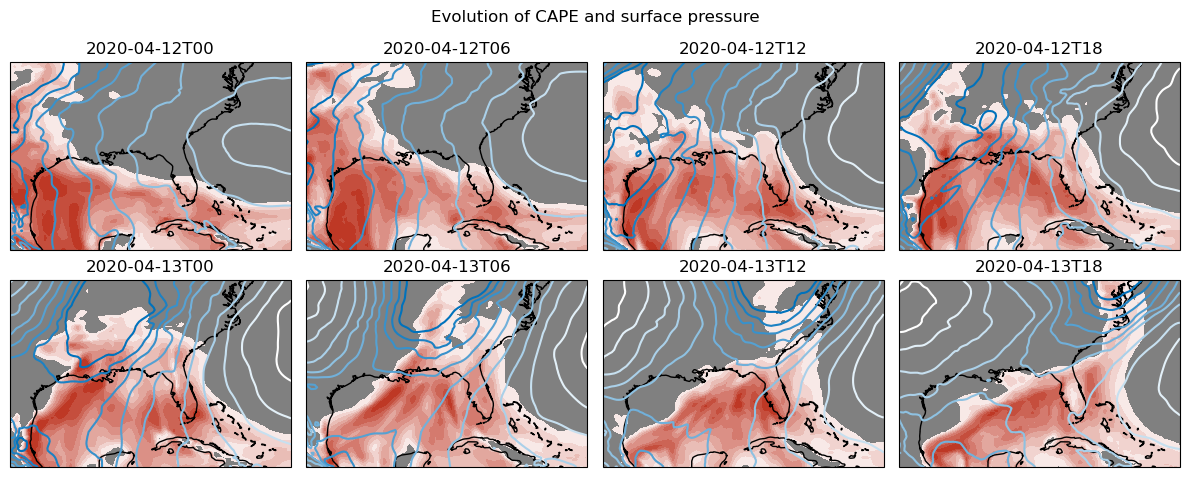

In [21]:
cm= colors.LinearSegmentedColormap.from_list('mycmap', ['#FFFFFF', '#BE3825'])
cm.set_under(color="grey")
cm.set_bad(color="grey")
cmd = colors.LinearSegmentedColormap.from_list('mycmap', ['#0072BC', '#FFFFFF'])  
print('making plot')
n=0
projection = ccrs.PlateCarree()
era_ref=era_ref.assign(mean_sea_level_pressure=lambda era_ref: xr_era5.mean_sea_level_pressure)
fig2,axes2 = plt.subplots(2,4,figsize=(12, 5), subplot_kw={'projection':ccrs.PlateCarree()})
axs_flat = axes2.flatten()
for i, ax in enumerate(axs_flat):
    data=era_ref.isel(time=n)

    contour_plot=data.cape.plot.contourf(ax=ax, transform=projection,x='longitude', y='latitude',
        cmap=cm,vmin=100,vmax=2500,levels=np.arange(100,2600,300),extend='both', add_colorbar=False)

    data.mean_sea_level_pressure.plot.contour(ax=ax, transform=projection, x='longitude', y='latitude',
         cmap=cmd,vmin=100000,vmax=103000,levels=np.arange(100000,103000,300),extend='both')


    ax.coastlines()
    ax.set_title('') # to supress xarray auto-title
    ax.set_title(np.datetime_as_string(data.time.values,unit='h'));
    n+=1
# cbar = fig2.colorbar(contour_plot, ax=axes2, orientation='horizontal', shrink=0.8)
# cbar.set_label('CAPE [J kg$^{-1}$]')
fig2.suptitle('Evolution of CAPE and surface pressure')
plt.tight_layout()
fig2.savefig(figpath+'plot_era5_cape_msl.png',  dpi=300, bbox_inches='tight')

In [31]:
np.datetime_as_string(data.time.values,unit='h')

'2020-04-13T18'

making plot


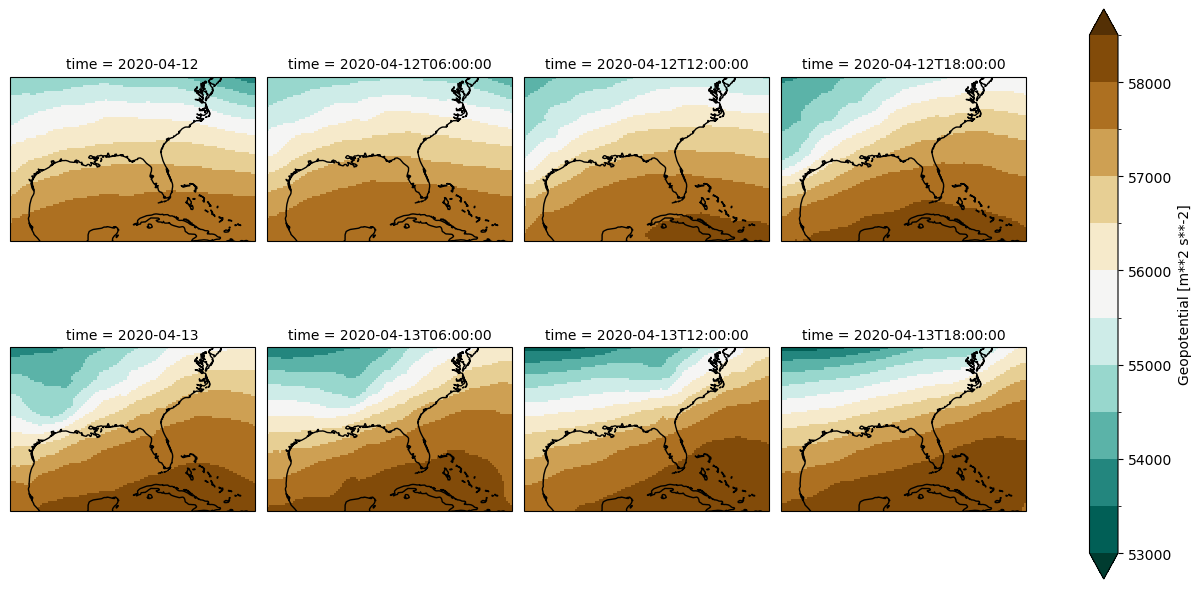

In [22]:
cm=plt.cm.Reds
cm.set_under(color="grey")
cm.set_bad(color="grey")
cmd=plt.cm.BrBG_r
print('making plot')
p = xr_era5.geopotential.sel(level=500,latitude=slice(20,40),longitude=slice(260,290)).plot(x='longitude', y='latitude', col='time', col_wrap=4,
            transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()},
            cmap=cmd,vmin=53000,vmax=59000,levels=np.arange(53000,59000,500),extend='both')# col_wrap=4)
for ax in p.axs.flat:
                ax.coastlines()
f=p.fig
f.savefig(figpath+'plot_era5_z500.png',  dpi=300, bbox_inches='tight')

making plot


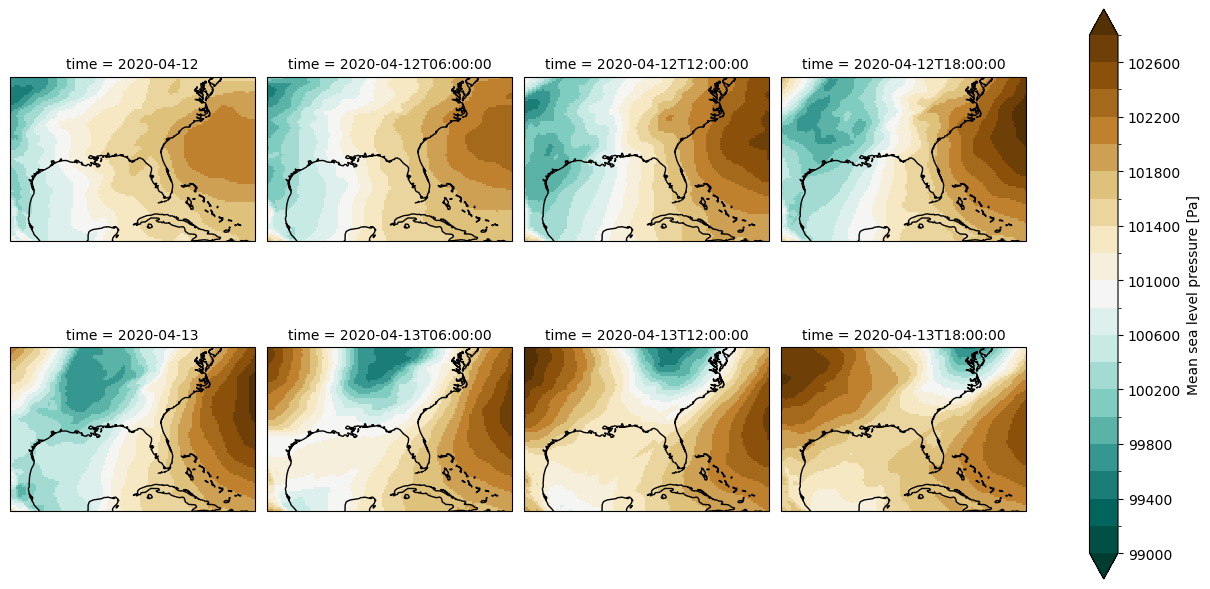

In [10]:
cm=plt.cm.Reds
cm.set_under(color="grey")
cm.set_bad(color="grey")
cmd=plt.cm.BrBG_r
print('making plot')
p = xr_era5.mean_sea_level_pressure.sel(latitude=slice(20,40),longitude=slice(260,290)).plot(x='longitude', y='latitude', col='time', col_wrap=4,
            transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()},
            cmap=cmd,vmin=99000,vmax=103000,levels=np.arange(99000,103000,200),extend='both')# col_wrap=4)
for ax in p.axs.flat:
                ax.coastlines()
f=p.fig
f.savefig(figpath+'plot_era5_msl.png',  dpi=300, bbox_inches='tight')

making plot


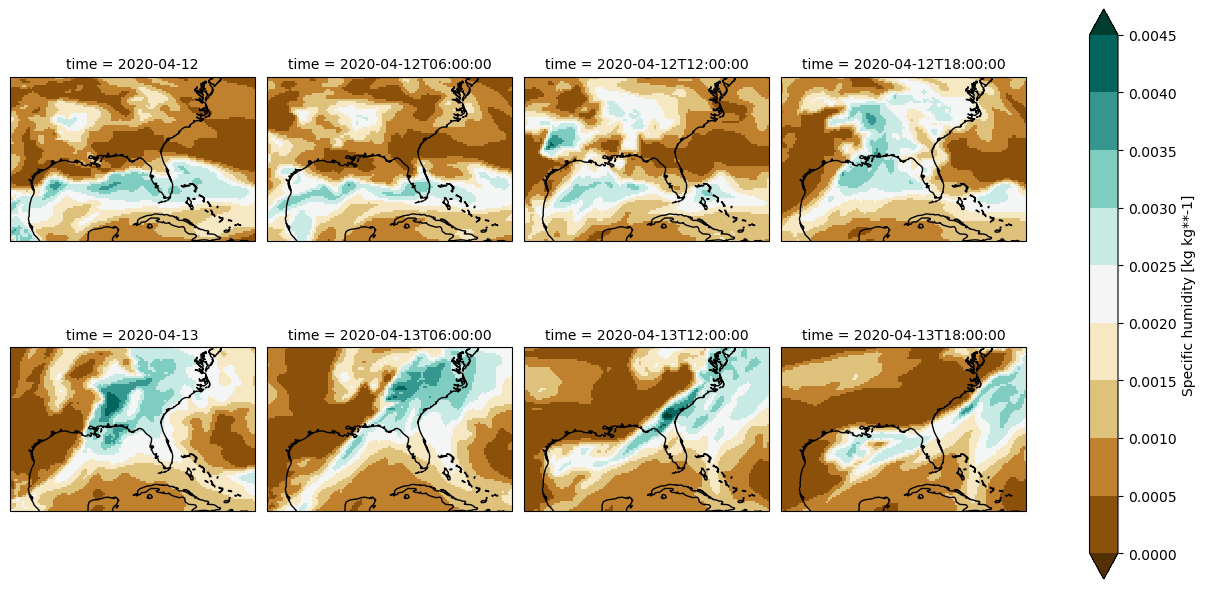

In [17]:
cm=plt.cm.Reds
cm.set_under(color="grey")
cm.set_bad(color="grey")
cmd=plt.cm.BrBG
print('making plot')
p = xr_era5.specific_humidity.sel(level=500,latitude=slice(20,40),longitude=slice(260,290)).plot(x='longitude', y='latitude', col='time', col_wrap=4,
            transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()},
            cmap=cmd,vmin=0,vmax=0.005,levels=np.arange(0,0.005,0.0005),extend='both')# col_wrap=4)
for ax in p.axs.flat:
                ax.coastlines()
f=p.fig
f.savefig(figpath+'plot_era5_q500.png',  dpi=300, bbox_inches='tight')

In [24]:
np.nanmax(xr_era5.temperature.sel(level=500,latitude=slice(20,40),longitude=slice(260,290)))

271.4873

making plot


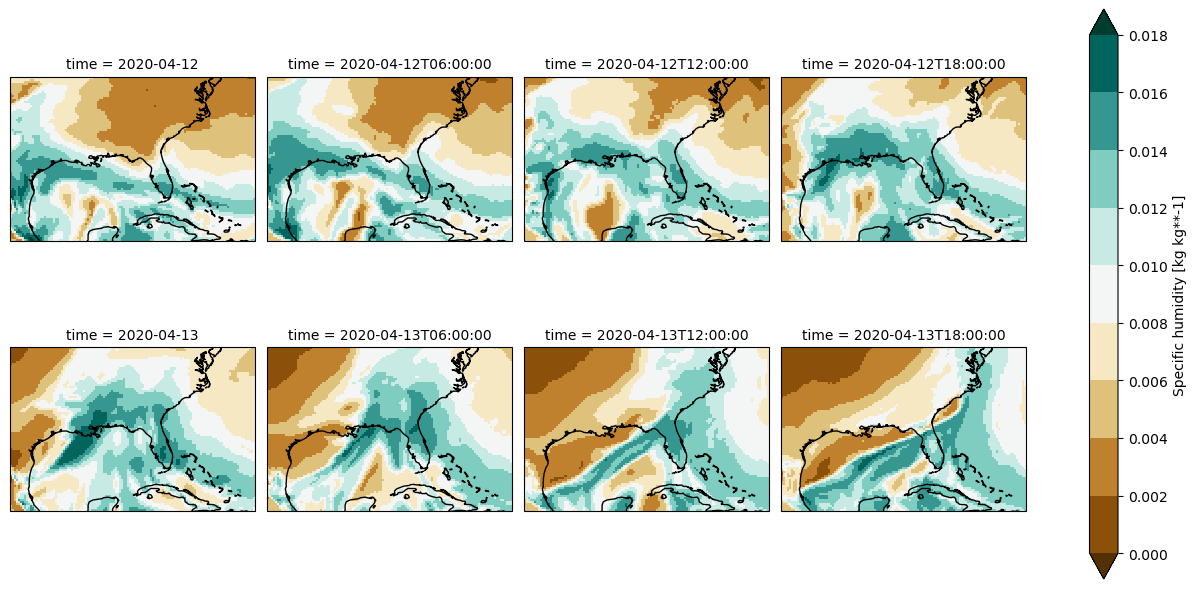

In [18]:
cm=plt.cm.Reds
cm.set_under(color="grey")
cm.set_bad(color="grey")
cmd=plt.cm.BrBG
print('making plot')
p = xr_era5.specific_humidity.sel(level=925,latitude=slice(20,40),longitude=slice(260,290)).plot(x='longitude', y='latitude', col='time', col_wrap=4,
            transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()},
            cmap=cmd,vmin=0,vmax=0.02,levels=np.arange(0,0.02,0.002),extend='both')# col_wrap=4)
for ax in p.axs.flat:
                ax.coastlines()
f=p.fig
f.savefig(figpath+'plot_era5_q925.png',  dpi=300, bbox_inches='tight')

making plot


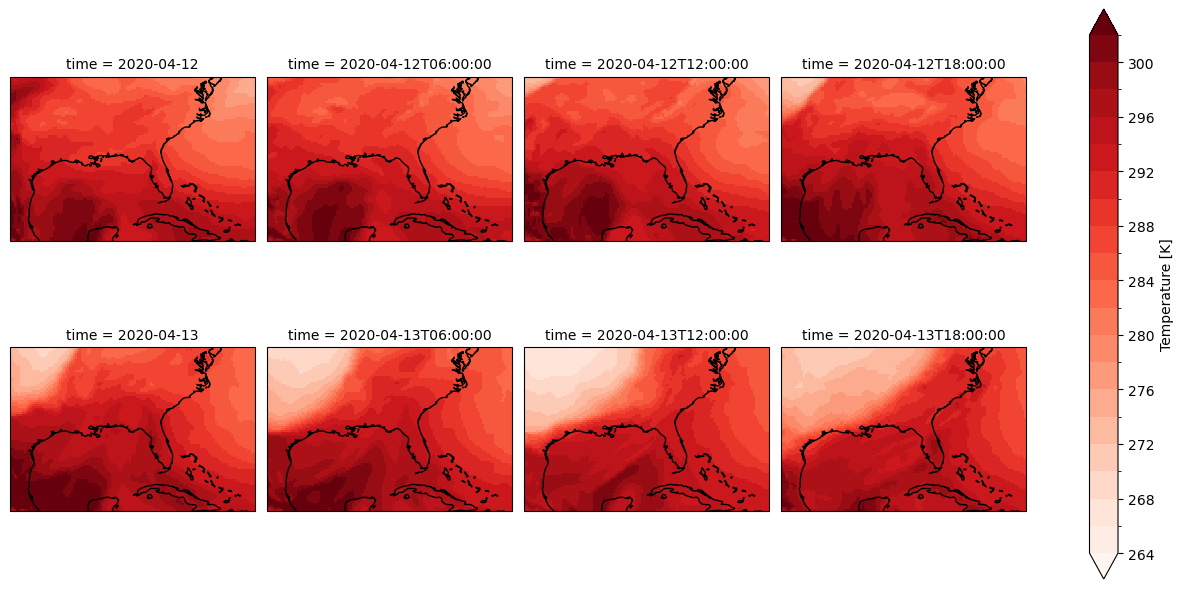

In [3]:
cm=plt.cm.Reds
cmd=plt.cm.BrBG
print('making plot')
p = xr_era5.temperature.sel(level=925,latitude=slice(20,40),longitude=slice(260,290)).plot(x='longitude', y='latitude', col='time', col_wrap=4,
            transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()},
            cmap=cm,vmin=265,vmax=303,levels=np.arange(264,303,2),extend='both')# col_wrap=4)
for ax in p.axs.flat:
                ax.coastlines()
f=p.fig
f.savefig(figpath+'plot_era5_t925.png',  dpi=300, bbox_inches='tight')

making plot


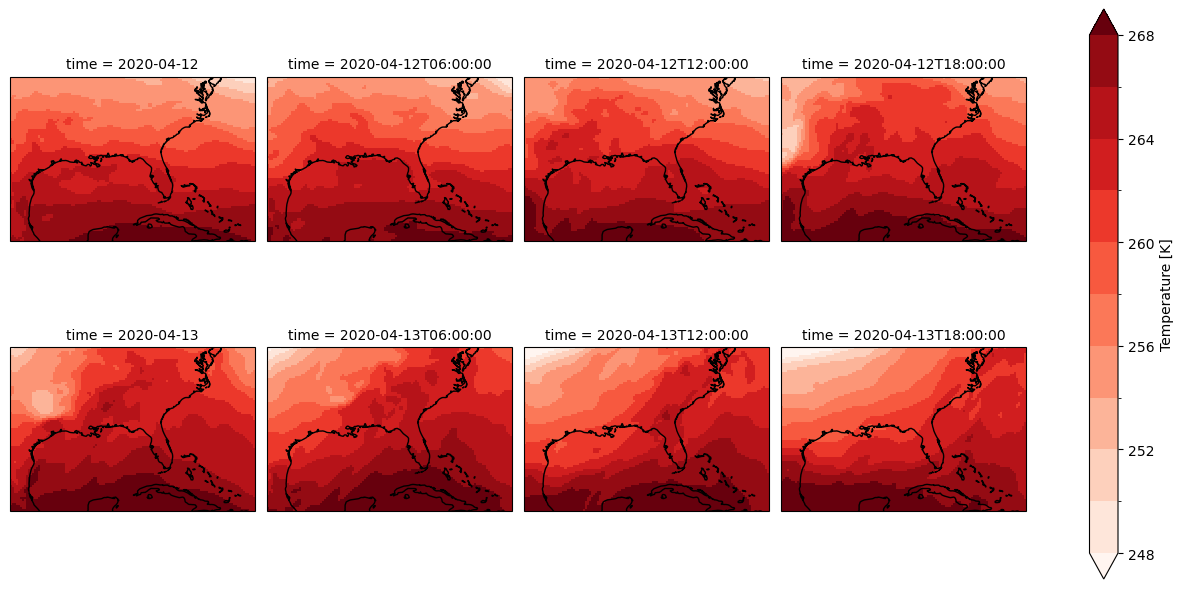

In [4]:
cm=plt.cm.Reds
cmd=plt.cm.BrBG
print('making plot')
p = xr_era5.temperature.sel(level=500,latitude=slice(20,40),longitude=slice(260,290)).plot(x='longitude', y='latitude', col='time', col_wrap=4,
            transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()},
            cmap=cm,vmin=248,vmax=269,levels=np.arange(248,269,2),extend='both')# col_wrap=4)
for ax in p.axs.flat:
                ax.coastlines()
f=p.fig
f.savefig(figpath+'plot_era5_t500.png',  dpi=300, bbox_inches='tight')